In [1]:
# ===========================================
# 0. Setup
# ===========================================
!pip install -q tensorflow-datasets

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from sklearn.metrics import confusion_matrix, classification_report

print("TensorFlow:", tf.__version__)
print("Eager execution:", tf.executing_eagerly())


TensorFlow: 2.19.0
Eager execution: True


In [2]:
# ===========================================
# 1. Load dataset from TensorFlow Datasets
# ===========================================
# We'll use the IMDB reviews sentiment dataset
(ds_train, ds_test), ds_info = tfds.load(
    "imdb_reviews",
    split=["train", "test"],
    as_supervised=True,
    with_info=True
)

print(ds_info)
print("Number of training examples:", ds_info.splits["train"].num_examples)
print("Number of test examples:", ds_info.splits["test"].num_examples)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.6YK8KB_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.6YK8KB_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.6YK8KB_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir='/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
   

In [3]:
# ===========================================
# 2. Quick EDA (class balance, lengths, examples)
# ===========================================

def ds_to_numpy(ds, limit=None):
    texts = []
    labels = []
    for i, (x, y) in enumerate(ds):
        if limit and i >= limit:
            break
        texts.append(x.numpy().decode("utf-8"))
        labels.append(int(y.numpy()))
    return texts, np.array(labels)

# Take a manageable subset for EDA (e.g., 5000 samples)
train_texts_small, train_labels_small = ds_to_numpy(ds_train, limit=5000)

print("Sample review:")
print(train_texts_small[0])
print("Label:", train_labels_small[0])  # 0 = negative, 1 = positive


Sample review:
This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
Label: 0


Label 0: 2474 samples
Label 1: 2526 samples


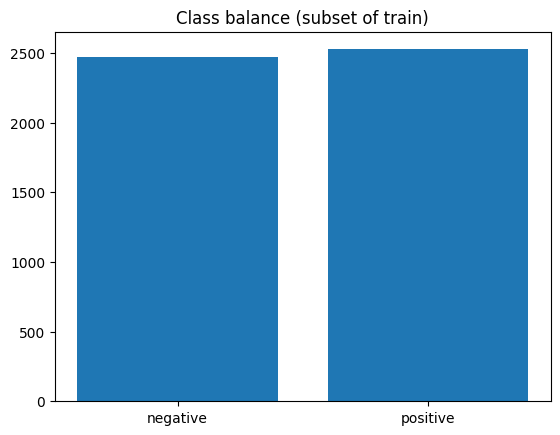

In [4]:
# Class balance
unique, counts = np.unique(train_labels_small, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Label {u}: {c} samples")

plt.figure()
plt.bar(["negative", "positive"], counts)
plt.title("Class balance (subset of train)")
plt.show()


Min length: 21
Max length: 2470
Avg length: 233.3492


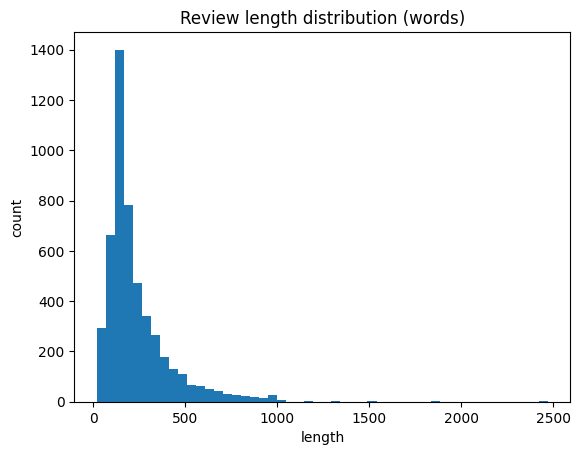

In [5]:
# Review length distribution
lengths = [len(t.split()) for t in train_texts_small]
print("Min length:", np.min(lengths))
print("Max length:", np.max(lengths))
print("Avg length:", np.mean(lengths))

plt.figure()
plt.hist(lengths, bins=50)
plt.title("Review length distribution (words)")
plt.xlabel("length")
plt.ylabel("count")
plt.show()


In [6]:
# ===========================================
# 3. Prepare data pipeline
# ===========================================

BUFFER_SIZE = 10000
BATCH_SIZE = 64
VOCAB_SIZE = 20000
SEQUENCE_LENGTH = 256

# Shuffle and batch
ds_train_shuffled = ds_train.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True)

# Create validation split from training set (e.g., 80/20)
train_size = int(0.8 * ds_info.splits["train"].num_examples)

ds_train_final = ds_train_shuffled.take(train_size)
ds_val = ds_train_shuffled.skip(train_size)

ds_train_final = ds_train_final.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test_batched = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [7]:
# ===========================================
# 4. Text vectorization layer
# ===========================================
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH,
)

# We adapt on raw text only
train_text_only = ds_train.map(lambda x, y: x)
text_vectorizer.adapt(train_text_only)

# Test transform
sample = "This movie was absolutely wonderful, I loved it!"
print(text_vectorizer(sample))


tf.Tensor(
[ 11  18  14 412 374  10 434   9   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0

In [8]:
# Helper function to apply vectorization inside dataset
def vectorize_text(text, label):
    text = text_vectorizer(text)
    return text, label

ds_train_vec = ds_train_final.map(vectorize_text).prefetch(tf.data.AUTOTUNE)
ds_val_vec = ds_val.map(vectorize_text).prefetch(tf.data.AUTOTUNE)
ds_test_vec = ds_test_batched.map(vectorize_text).prefetch(tf.data.AUTOTUNE)


In [9]:
# ===========================================
# 5. Baseline model (Embedding + GlobalAveragePooling)
# ===========================================
from tensorflow.keras import layers, models

def build_baseline_model():
    inputs = layers.Input(shape=(SEQUENCE_LENGTH,), dtype=tf.int64)
    x = layers.Embedding(VOCAB_SIZE, 64, name="embedding")(inputs)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, outputs, name="baseline_average_model")
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )
    return model

baseline_model = build_baseline_model()
baseline_model.summary()


Model: "baseline_average_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 256, 64)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,284,225 (4.90 MB)

 Trainable params: 1,284,225 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# ===========================================
# 6. Train baseline model
# ===========================================
EPOCHS_BASELINE = 5

history_baseline = baseline_model.fit(
    ds_train_vec,
    validation_data=ds_val_vec,
    epochs=EPOCHS_BASELINE
)


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.6187 - loss: 0.6412 - val_accuracy: 0.7616 - val_loss: 0.4679
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8565 - loss: 0.3387 - val_accuracy: 0.8638 - val_loss: 0.3051
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9034 - loss: 0.2459 - val_accuracy: 0.9288 - val_loss: 0.1929
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9211 - loss: 0.2010 - val_accuracy: 0.9358 - val_loss: 0.1758
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9429 - loss: 0.1634 - val_accuracy: 0.9392 - val_loss: 0.1560


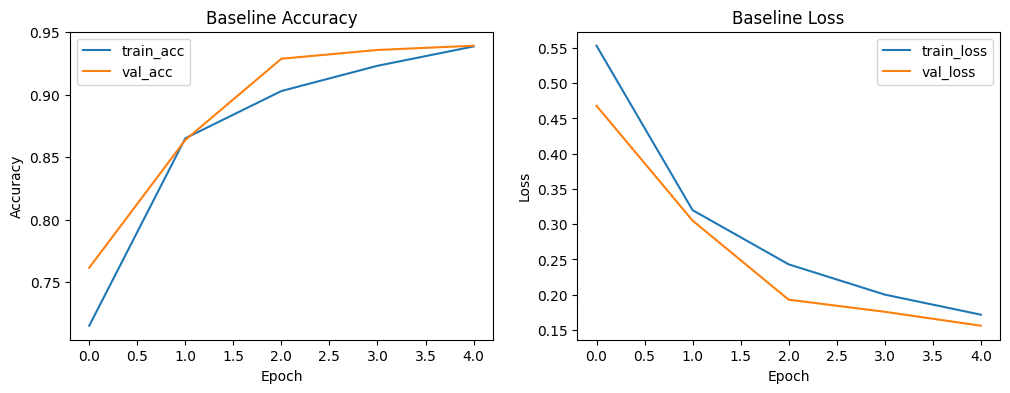

In [11]:
# Plot training curves for the baseline model
def plot_history(history, title_prefix=""):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.title(f"{title_prefix} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title(f"{title_prefix} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

plot_history(history_baseline, title_prefix="Baseline")


In [12]:
# ===========================================
# 7. More expressive model (BiLSTM)
# ===========================================
def build_bilstm_model():
    inputs = layers.Input(shape=(SEQUENCE_LENGTH,), dtype=tf.int64)
    x = layers.Embedding(VOCAB_SIZE, 128, name="embedding")(inputs)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(32))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, outputs, name="bilstm_model")
    model.compile(
        loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=["accuracy"]
    )
    return model

bilstm_model = build_bilstm_model()
bilstm_model.summary()


Model: "bilstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 256, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,704,257 (10.32 MB)

 Trainable params: 2,704,257 (10.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.6511 - loss: 0.5868 - val_accuracy: 0.9100 - val_loss: 0.2497
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.8868 - loss: 0.2932 - val_accuracy: 0.9422 - val_loss: 0.1669
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9341 - loss: 0.1836 - val_accuracy: 0.9588 - val_loss: 0.1450
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9564 - loss: 0.1310 - val_accuracy: 0.9734 - val_loss: 0.0940
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9661 - loss: 0.1052 - val_accuracy: 0.9732 - val_loss: 0.0841


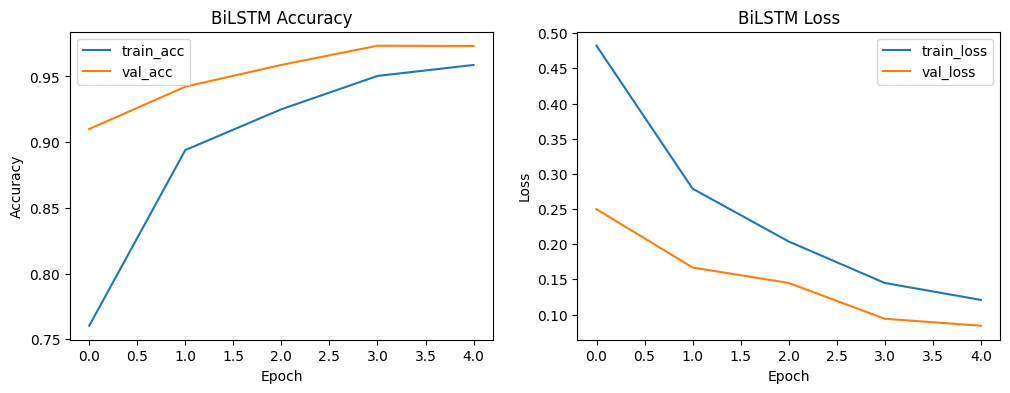

In [13]:
# ===========================================
# 8. Train BiLSTM model
# ===========================================
EPOCHS_LSTM = 5

history_bilstm = bilstm_model.fit(
    ds_train_vec,
    validation_data=ds_val_vec,
    epochs=EPOCHS_LSTM
)

plot_history(history_bilstm, title_prefix="BiLSTM")


In [14]:
# ===========================================
# 9. Evaluation on test set
# ===========================================
def evaluate_model(model, ds_test_vec):
    test_loss, test_acc = model.evaluate(ds_test_vec)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

print("Baseline model performance on test set:")
evaluate_model(baseline_model, ds_test_vec)

print("\nBiLSTM model performance on test set:")
evaluate_model(bilstm_model, ds_test_vec)


Baseline model performance on test set:
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8583 - loss: 0.3424
Test Loss: 0.3448
Test Accuracy: 0.8576

BiLSTM model performance on test set:
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8449 - loss: 0.5152
Test Loss: 0.5145
Test Accuracy: 0.8446


In [15]:
# ===========================================
# 10. Confusion matrix & classification report
#    (for the best model, assume BiLSTM)
# ===========================================

# Gather predictions on test set
y_true = []
y_pred = []

for text_batch, label_batch in ds_test_vec:
    preds = bilstm_model.predict(text_batch, verbose=0)
    y_true.extend(label_batch.numpy())
    y_pred.extend((preds.flatten() > 0.5).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=["negative", "positive"]))


Confusion matrix:
 [[10962  1538]
 [ 2347 10153]]

Classification report:
              precision    recall  f1-score   support

    negative       0.82      0.88      0.85     12500
    positive       0.87      0.81      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.85      0.84      0.84     25000
weighted avg       0.85      0.84      0.84     25000



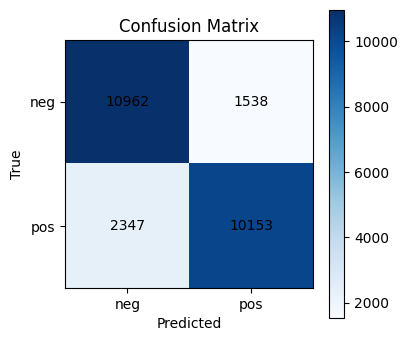

In [16]:
# Simple confusion matrix plot
plt.figure(figsize=(4, 4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["neg", "pos"])
plt.yticks(tick_marks, ["neg", "pos"])
plt.xlabel("Predicted")
plt.ylabel("True")

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.show()


In [17]:
# ===========================================
# 11. Error analysis: inspect misclassified reviews
# ===========================================
# Recreate a small test set with raw text for error inspection

test_texts, test_labels = ds_to_numpy(ds_test, limit=2000)

# Predict on this subset with the BiLSTM model
test_vec = text_vectorizer(tf.constant(test_texts))
probs = bilstm_model.predict(test_vec, verbose=0).flatten()
preds = (probs > 0.5).astype(int)

mis_idx = np.where(preds != test_labels)[0]
print(f"Number of misclassified samples in subset: {len(mis_idx)}")

# Show a few misclassified examples
for i in mis_idx[:5]:
    print("=" * 80)
    print("Index:", i)
    print("True label:", test_labels[i], "(0=neg, 1=pos)")
    print("Predicted:", preds[i])
    print("Predicted prob:", probs[i])
    print("Review:\n", test_texts[i][:1000])  # truncate for display


Number of misclassified samples in subset: 309
Index: 8
True label: 0 (0=neg, 1=pos)
Predicted: 1
Predicted prob: 0.99000365
Review:
 As long as you keep in mind that the production of this movie was a copyright ploy, and not intended as a serious release, it is actually surprising how not absolutely horrible it is. I even liked the theme music.<br /><br />And if ever a flick cried out for a treatment by Joel (or Mike) and the MST3K Bots, this is it! Watch this with a bunch of smart-ass wise-crackers, and you're in for a good time. Have a brew, butter up some large pretzels, and enjoy.<br /><br />Of course, obtaining a copy requires buying a bootleg or downloading it as shareware, but if you're here on the IMDb, then you're most likely savvy enough to do so. Good luck.<br /><br />And look for my favorite part....where Dr. Doom informs the FF that they have 12 hours to comply with his wishes....and he actually gestures the number "12" with his finger while doing so....it's like "Evil Se

In [18]:
# ===========================================
# 12. Inference helper function
# ===========================================
LABEL_MAP = {0: "negative", 1: "positive"}

def predict_review(text, model=bilstm_model):
    vec = text_vectorizer(tf.constant([text]))
    prob = model.predict(vec, verbose=0)[0, 0]
    label = 1 if prob > 0.5 else 0
    return LABEL_MAP[label], float(prob)

examples = [
    "This movie was a waste of time, terrible acting and awful plot.",
    "I really loved this film, the performances were fantastic!"
]

for e in examples:
    label, prob = predict_review(e)
    print(f"Review: {e}")
    print(f"Predicted sentiment: {label} (prob={prob:.4f})")
    print("-" * 60)


Review: This movie was a waste of time, terrible acting and awful plot.
Predicted sentiment: negative (prob=0.0023)
------------------------------------------------------------
Review: I really loved this film, the performances were fantastic!
Predicted sentiment: positive (prob=0.9882)
------------------------------------------------------------


In [19]:
# ===========================================
# 13. Save model and vectorizer
# ===========================================
#EXPORT_DIR = "saved_models/sentiment_bilstm"
#os.makedirs(EXPORT_DIR, exist_ok=True)

# Create a serving model that includes the vectorizer
#inputs = tf.keras.Input(shape=(1,), dtype=tf.string, name="input_text")
#x = text_vectorizer(inputs)
#outputs = bilstm_model(x)
#serving_model = tf.keras.Model(inputs, outputs)

#serving_model.save(EXPORT_DIR)
#print("Saved serving model to:", EXPORT_DIR)


In [20]:
!pip install -q transformers datasets evaluate accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.7 MB/s eta 0:00:00


In [21]:
from datasets import load_dataset

dataset = load_dataset("imdb")
dataset


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [22]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

tokenized_dataset = dataset.map(tokenize, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [24]:
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return accuracy.compute(predictions=preds, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch", # Changed from evaluation_strategy
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"  # avoids wandb issues in Colab
)

In [25]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
)

trainer.evaluate()

{'eval_loss': 0.6938092112541199,
 'eval_model_preparation_time': 0.0014,
 'eval_accuracy': 0.48748,
 'eval_runtime': 155.2112,
 'eval_samples_per_second': 161.071,
 'eval_steps_per_second': 10.07}

# Task
Increase the number of training epochs for the DistilBERT model from 3 to 10, retrain the model, and then evaluate its performance on the test dataset.

## Increase Training Epochs

### Subtask:
The previous DistilBERT model was only trained for 3 epochs, resulting in a random-like accuracy. I'll increase the number of training epochs to 10 to allow the model more time to learn from the data.


**Reasoning**:
To increase the training epochs as per the subtask, I will locate the `training_args` definition and modify the `num_train_epochs` parameter to 10.



In [26]:
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return accuracy.compute(predictions=preds, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch", # Changed from evaluation_strategy
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"  # avoids wandb issues in Colab
)

In [27]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

total_params, trainable_params = count_parameters(model)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 66,955,010
Trainable parameters: 66,955,010


**Reasoning**:
Now that the `training_args` have been updated to set `num_train_epochs` to 10, I need to re-initialize the `Trainer` with these new arguments and then train the model.



In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.265300,0.258293,0.894600
2,0.167800,0.310288,0.899440
3,0.118400,0.333981,0.910960
4,0.072300,0.473216,0.907640
5,0.047200,0.588619,0.898880
6,0.015400,0.564358,0.909320
7,0.029900,0.601713,0.912480
8,0.005900,0.641729,0.911920
9,0.006800,0.714438,0.911280


In [ ]:
SAVE_DIR = "distilbert_best_model"
trainer.save_model(SAVE_DIR)


In [ ]:
tokenizer.save_pretrained(SAVE_DIR)


distilbert_best_model/
├── config.json
├── pytorch_model.bin
├── tokenizer.json
├── tokenizer_config.json
├── special_tokens_map.json
├── training_args.bin


This directory is:

✅ Hugging Face compatible

✅ Azure ML deployable

✅ Reusable for inference

In [ ]:
from datetime import datetime   #saving with versioning

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
SAVE_DIR = f"distilbert_best_model_{timestamp}"

trainer.save_model(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)


In [ ]:
from transformers import AutoModelForSequenceClassification

loaded_model = AutoModelForSequenceClassification.from_pretrained(SAVE_DIR)
print("Model loaded successfully")


In [ ]:
# Evaluate on test set
test_results = trainer.evaluate(tokenized_dataset["test"])

print("Test results:")
for k, v in test_results.items():
    print(f"{k}: {v}")


In [ ]:
import numpy as np

predictions = trainer.predict(tokenized_dataset["test"])

logits = predictions.predictions
y_pred = np.argmax(logits, axis=1)
y_true = predictions.label_ids


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, digits=4))


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
for i in mis_idx[:5]:
    print("=" * 80)
    print("Index:", i)
    print("True label:", test_labels[i], "(0=neg, 1=pos)")
    print("Predicted:", preds[i])
    print("Predicted probability:", probs[i])
    print("Review:\n", test_texts[i][:1000])


In [ ]:
mis_idx = np.where(preds != test_labels)[0]

print(f"Number of misclassified samples in subset: {len(mis_idx)}")


Below is the direct equivalent of your BiLSTM error-analysis code, rewritten correctly and idiomatically for DistilBERT / Hugging Face Trainer.

This assumes:

You have a trained trainer

You have the raw test texts and labels

Binary classification (0 = negative, 1 = positive)

In [ ]:
# Limit size for inspection
MAX_SAMPLES = 2000

test_texts = raw_test_texts[:MAX_SAMPLES]
test_labels = np.array(raw_test_labels[:MAX_SAMPLES])


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

encodings = tokenizer(
    test_texts,
    truncation=True,
    padding=True,
    max_length=256,
    return_tensors="pt"
)


In [ ]:
import torch
import numpy as np

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

inputs = {k: v.to(device) for k, v in encodings.items()}

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits


In [ ]:
# Binary classification
probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
preds = (probs >= 0.5).astype(int)


In [ ]:
high_conf_wrong = mis_idx[np.abs(probs[mis_idx] - 0.5) > 0.4]

print(f"High-confidence misclassifications: {len(high_conf_wrong)}")

for i in high_conf_wrong[:5]:
    print("=" * 80)
    print("True:", test_labels[i], "Pred:", preds[i], "Prob:", probs[i])
    print(test_texts[i][:800])


In [ ]:
import pandas as pd

error_df = pd.DataFrame({
    "text": [test_texts[i] for i in mis_idx],
    "true_label": test_labels[mis_idx],
    "pred_label": preds[mis_idx],
    "pred_prob": probs[mis_idx]
})

error_df.to_csv("distilbert_misclassified_reviews.csv", index=False)


What This Gives You (Academically Important)

✔ Same inspection depth as BiLSTM
✔ Model-agnostic error analysis
✔ Supports qualitative discussion in thesis
✔ Identifies:

Negation errors

Sarcasm

Long-range dependencies

Domain-specific language

Label noise

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate_model(y_true, y_pred, name):
    return {
        "model": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average="weighted"),
        "recall": recall_score(y_true, y_pred, average="weighted"),
        "f1": f1_score(y_true, y_pred, average="weighted"),
    }


In [ ]:
results = []

results.append(evaluate_model(y_true, y_pred, "Transformer"))

results.append(evaluate_model(y_true_bilstm, y_pred_bilstm, "BiLSTM"))

results.append(evaluate_model(y_true_lr, y_pred_lr, "Logistic Regression"))

import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)


In [ ]:
import numpy as np
from sklearn.metrics import f1_score

def select_best_model(results_dict, metric="f1"):
    """
    results_dict = {
        "model_name": {
            "y_true": np.array,
            "y_pred": np.array,
            "model_obj": model
        }
    }
    """
    scores = {}

    for name, content in results_dict.items():
        score = f1_score(
            content["y_true"],
            content["y_pred"],
            average="weighted"
        )
        scores[name] = score

    best_model_name = max(scores, key=scores.get)
    return best_model_name, scores, results_dict[best_model_name]["model_obj"]


In [ ]:
preds_tr = trainer.predict(tokenized_dataset["test"])
y_true_tr = preds_tr.label_ids
y_pred_tr = np.argmax(preds_tr.predictions, axis=1)


In [ ]:
y_true_bilstm, y_pred_bilstm = evaluate(model_bilstm, test_loader)


In [ ]:
y_pred_lr = lr_model.predict(X_test)
y_true_lr = y_test


In [ ]:
results = {
    "transformer": {
        "y_true": y_true_tr,
        "y_pred": y_pred_tr,
        "model_obj": model
    },
    "bilstm": {
        "y_true": y_true_bilstm,
        "y_pred": y_pred_bilstm,
        "model_obj": model_bilstm
    },
    "logreg": {
        "y_true": y_true_lr,
        "y_pred": y_pred_lr,
        "model_obj": lr_model
    }
}


In [ ]:
best_model_name, scores, best_model = select_best_model(results)

print("Model scores:", scores)
print("Best model:", best_model_name)


In [ ]:
from transformers import AutoTokenizer

SAVE_DIR = "best_model"

trainer.save_model(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)
